GitHub Repository - https://github.com/dimong4/GenCheckAiModel.

This project was prepared using images generated by the Yandex Art model in the Shedevrum application.

The images are provided solely for the research purposes of this project to a Yandex Lyceum graduate and are not intended for public use.

In [ ]:
!pip install pytorch-metric-learning

In [ ]:
import os
from PIL import Image

import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, models
import numpy as np
from tqdm.auto import tqdm
from pytorch_metric_learning import losses, miners
from transformers import CLIPModel
from catboost import CatBoostClassifier
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve
)
import seaborn as sns

import random
import os
import random


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 10

SEED = 42
seed_everything(SEED)

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
path_dict = {
    "kandinskiy": [
        '/kaggle/input/tiny-ai-detect-kandinskiy/dataset/train',
        '/kaggle/input/tiny-ai-detect-kandinskiy/dataset/test',
        '/kaggle/input/tiny-ai-detect-kandinskiy/dataset/val'
    ],
    "yandex": [
        '/kaggle/input/tiny-ai-detect-yandexart/dataset_y/train',
        '/kaggle/input/tiny-ai-detect-yandexart/dataset_y/test',
        '/kaggle/input/tiny-ai-detect-yandexart/dataset_y/val'
    ],
    "biggan": [
        '/kaggle/input/tiny-genimage/imagenet_ai_0419_biggan/train',
        '/kaggle/input/tiny-genimage/imagenet_ai_0419_biggan/val'
    ],
    "vqbm": [
        '/kaggle/input/tiny-genimage/imagenet_ai_0419_vqdm/train',
        '/kaggle/input/tiny-genimage/imagenet_ai_0419_vqdm/val'
    ],
    "sdv5": [
        '/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/train',
        '/kaggle/input/tiny-genimage/imagenet_ai_0424_sdv5/val'
    ],
    "wukong": [
        '/kaggle/input/tiny-genimage/imagenet_ai_0424_wukong/train',
        '/kaggle/input/tiny-genimage/imagenet_ai_0424_wukong/val'
    ],
    "adm": [
        '/kaggle/input/tiny-genimage/imagenet_ai_0508_adm/train',
        '/kaggle/input/tiny-genimage/imagenet_ai_0508_adm/val'
    ],
    "glide": [
        '/kaggle/input/tiny-genimage/imagenet_glide/train',
        '/kaggle/input/tiny-genimage/imagenet_glide/val'
    ],
    "midjourney": [
        '/kaggle/input/tiny-genimage/imagenet_midjourney/train',
        '/kaggle/input/tiny-genimage/imagenet_midjourney/val'
    ]
}
def load_data(train_path, valid_path, test_path=None, batch_size=10):
    train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    valid_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_dataset = torchvision.datasets.ImageFolder(train_path, train_transforms)
    valid_dataset = torchvision.datasets.ImageFolder(valid_path, valid_transforms)

    if test_path is None:
        val_size = len(valid_dataset) //2
        test_size = len(valid_dataset) - val_size
        valid_dataset, test_dataset = torch.utils.data.random_split(
            valid_dataset,
            [val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )
    else:
        test_dataset = torchvision.datasets.ImageFolder(test_path, test_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, valid_dataset, test_dataset, train_dataloader, valid_dataloader, test_dataloader

names_dataloaders = ["kandinskiy", "yandex", "biggan", "vqbm", "sdv5", "wukong", "adm", "glide", "midjourney"]
train_datasets = []
valid_datasets = []
test_datasets = []

train_dataloaders = []
valid_dataloaders = []
test_dataloaders = []
for name in path_dict.keys():
    train, val, test, train_loader, val_loader, test_loader = load_data(path_dict[name][0], path_dict[name][1], path_dict[name][2] if len(path_dict[name]) == 3 else None)
    train_datasets.append(train)
    valid_datasets.append(val)
    test_datasets.append(test)

    train_dataloaders.append(train_loader)
    valid_dataloaders.append(val_loader)
    test_dataloaders.append(test_loader)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(train_datasets), batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(valid_datasets), batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset(test_datasets), batch_size=batch_size, shuffle=False)

In [ ]:
type(test_dataloader)

torch.utils.data.dataloader.DataLoader

In [ ]:
X, y = next(iter(test_dataloader))
print(X.shape)

Learning function with calculation of loss functions and accuracy metrics

In [ ]:
def train(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs=10):
    losses_t = []
    losses_v = []
    accuracy_t = []
    accuracy_v = []
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        train_num_correct = 0
        train_num_examples = 0
        for idx, batch in enumerate(train_loader):
            if idx % 1000 == 0:
                print(idx, idx / len(train_loader))
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]
        train_loss /= len(train_loader.dataset)

        model.eval()
        valid_num_correct = 0
        valid_num_examples = 0
        for batch in valid_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            valid_num_correct += torch.sum(correct).item()
            valid_num_examples += correct.shape[0]
        valid_loss /= len(valid_loader.dataset)
        losses_t.append(train_loss)
        losses_v.append(valid_loss)
        accuracy_t.append(train_num_correct / train_num_examples)
        accuracy_v.append(valid_num_correct / valid_num_examples)
        print('Epoch: {}, train loss: {:.2f}, valid loss: {:.2f},train accuracy: {:.2f}, valid accuracy: {:.2f}'\
              .format(epoch, train_loss, valid_loss, train_num_correct / train_num_examples, valid_num_correct / valid_num_examples))
    return losses_t, losses_v, accuracy_t, accuracy_v

Model testing function

In [ ]:
def test(model,test_loader):
    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in test_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]

    return 'accuracy: {:.2f}'.format(num_correct/num_examples)


# ResNet50

In [ ]:
stats = []
for i in range(9):
    model = models.resnet50(weights=None)
    weights_path = "/kaggle/input/resnet50/pytorch/default/1/resnet50-0676ba61.pth"
    state_dict = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state_dict)
    print("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    losses_curr, losses_curr, accuracy_curr, accuracy_curr = train(model, optimizer, loss_fn, train_dataloaders[i], valid_dataloaders[i], n_epochs=10)
    stats.append((losses_curr, losses_curr, accuracy_curr, accuracy_curr))
    print(f"Accuracy while training on {names_dataloaders[i]}")
    print(f"Test on {names_dataloaders[i]}: {test(model, test_dataloaders[i])}", end="\n")
    for j in range(len(test_dataloaders)):
        print(f"Test on {names_dataloaders[j]}: {test(model, test_dataloaders[j])}", end="\n")

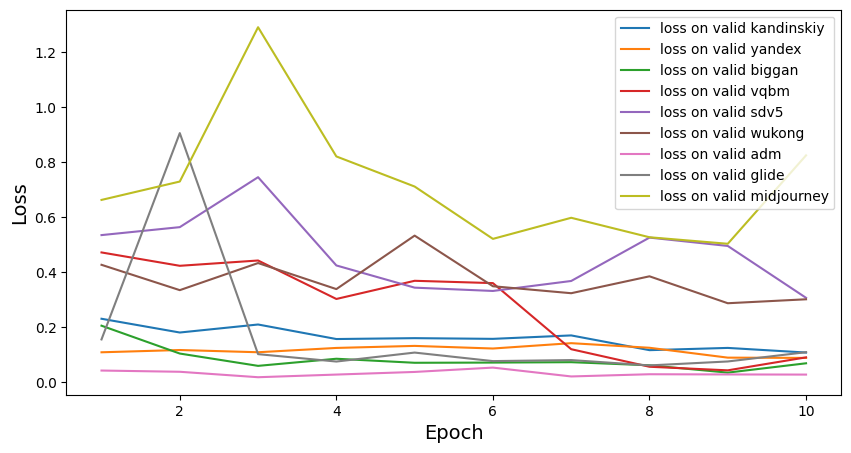

In [ ]:
x = range(1, 11)
fig = plt.figure(figsize=(10, 5))
for i in range(9):
    #plt.plot(x, stats[i][0], label=f'loss on train {names_dataloaders[i]}')
    plt.plot(x, stats[i][1], label=f'loss on valid {names_dataloaders[i]}')
plt.legend()
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
fig.savefig("losses")
fig.show()

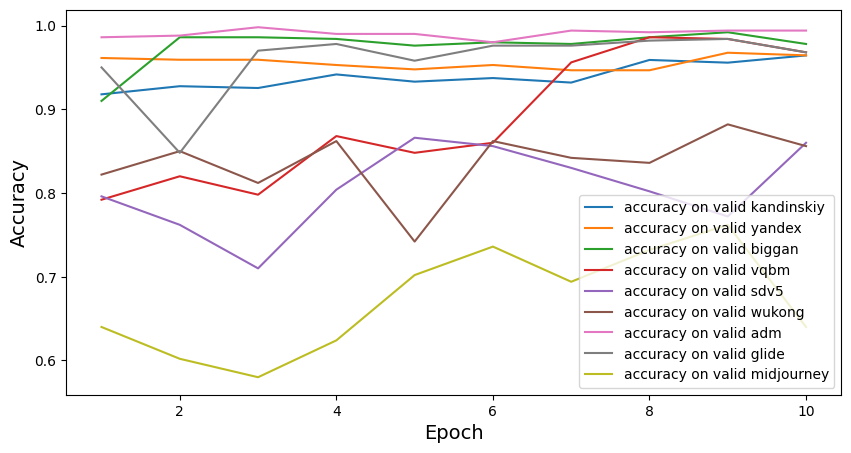

In [ ]:
x = range(1, 11)
fig = plt.figure(figsize=(10, 5))
for i in range(9):
    #plt.plot(x, stats[i][2], label=f'accuracy on train {names_dataloaders[i]}')
    plt.plot(x, stats[i][3], label=f'accuracy on valid {names_dataloaders[i]}')
plt.legend()
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
fig.savefig("accs")
fig.show()

# Swin-T

In [ ]:
n_classes=2
stats_swin = []
for i in range(9):
    model = models.swin_t(weights=None)
    weights_path = "/kaggle/input/swin-t-imagenet1k/pytorch/default/1/swin_t-704ceda3.pth"
    state_dict = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(state_dict)
    num_features = model.head.in_features
    model.head = torch.nn.Linear(num_features, n_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=3e-5,
        weight_decay=0.05
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=5,
        eta_min=1e-6
    )
    dummy_input = torch.randn(2, 3, 256, 256).to(device)
    output = model(dummy_input)
    print(output)
    losses_curr, losses_curr, accuracy_curr, accuracy_curr = train(model, optimizer, loss_fn, train_dataloaders[i], valid_dataloaders[i], n_epochs=5)
    stats_swin.append((losses_curr, losses_curr, accuracy_curr, accuracy_curr))
    print(f"Accuracy while training on {names_dataloaders[i]}")
    print(f"Test on {names_dataloaders[i]}: {test(model, test_dataloaders[i])}", end="\n")
    for j in range(len(test_dataloaders)):
        print(f"Test on {names_dataloaders[j]}: {test(model, test_dataloaders[j])}", end="\n")

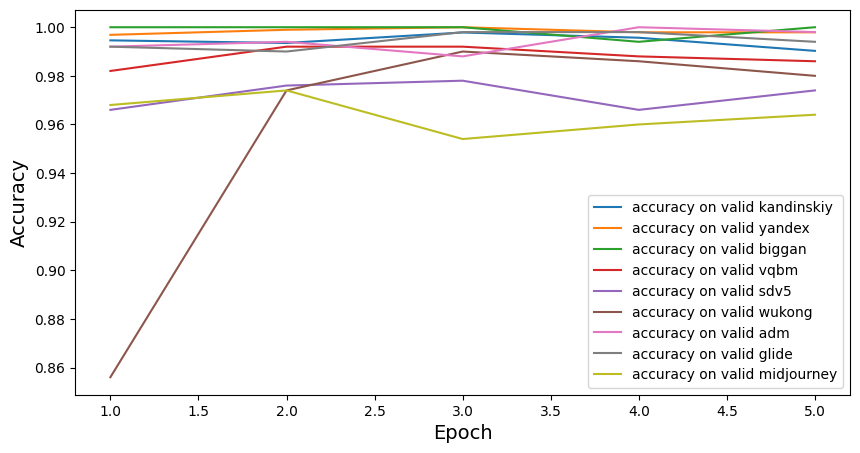

In [ ]:
x = range(1, len(stats_swin[i][3])+1)
fig = plt.figure(figsize=(10, 5))
for i in range(9):
    #plt.plot(x, stats[i][2], label=f'accuracy on train {names_dataloaders[i]}')
    plt.plot(x, stats_swin[i][3], label=f'accuracy on valid {names_dataloaders[i]}')
plt.legend()
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
fig.savefig("accs_swin")
fig.show()

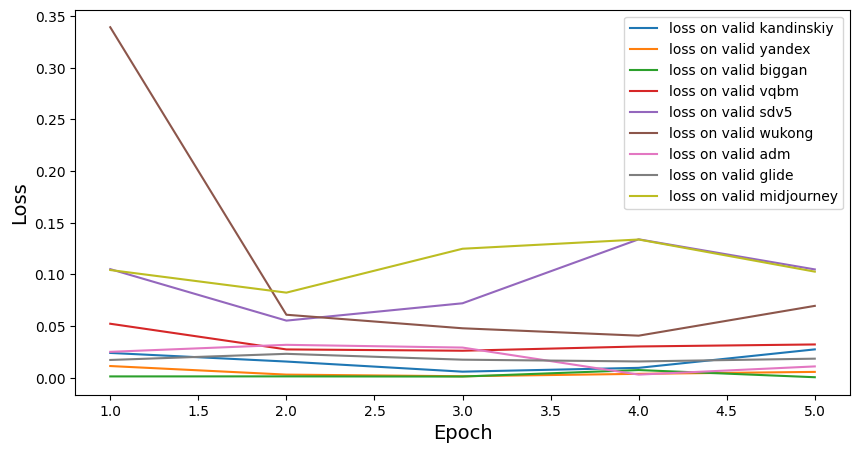

In [ ]:
x = range(1, len(stats_swin[i][1])+1)
fig = plt.figure(figsize=(10, 5))
for i in range(9):
    #plt.plot(x, stats[i][0], label=f'loss on train {names_dataloaders[i]}')
    plt.plot(x, stats_swin[i][1], label=f'loss on valid {names_dataloaders[i]}')
plt.legend()
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
fig.savefig("losses_swin")
fig.show()

# CLIP

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("/kaggle/input/clip/transformers/default/1").to(device)
processor = CLIPProcessor.from_pretrained("/kaggle/input/clip/transformers/default/1")
model.eval()

real_prompts = [
    "a photo", "raw photo", "shot on iPhone", "film grain",
    "camera noise", "natural skin texture", "candid shot", "imperfections"
]

fake_prompts = [
    "ai generated image", "3d render", "unreal engine 5", "smooth plastic skin",
    "waxy texture", "artificial lighting", "distorted details", "digital art"
]

all_prompts = real_prompts + fake_prompts
n_real = len(real_prompts)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def unnormalize(tensor):
    return (tensor * std + mean).clamp(0, 1)

y_true_list = []
y_probs_real_list = []
visual_limit = 2
count = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        for i in range(len(images)):
            img_tensor = unnormalize(images[i].cpu())
            img_pil = transforms.ToPILImage()(img_tensor)

            inputs = processor(text=all_prompts, images=img_pil, return_tensors="pt", padding=True).to(device)
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1).squeeze().cpu().numpy()

            score_real = probs[:n_real].sum()
            score_fake = probs[n_real:].sum()
            total_score = score_real + score_fake
            final_prob_real = score_real / total_score
            final_prob_fake = score_fake / total_score

            y_true_list.append(labels[i].item())
            y_probs_real_list.append(final_prob_real)

            if count < visual_limit:
                if final_prob_fake > final_prob_real:
                    pred_label, confidence, color = "AI Generated", final_prob_fake, "red"
                else:
                    pred_label, confidence, color = "Real Photo", final_prob_real, "green"

                plt.figure(figsize=(4, 4))
                plt.imshow(img_pil)
                plt.axis("off")
                title_text = (f"Pred: {pred_label} ({confidence:.1%})\n"
                              f"True Label (idx): {labels[i]}\n"
                              f"Score Fake: {final_prob_fake:.2f} | Score Real: {final_prob_real:.2f}")
                plt.title(title_text, color=color, fontsize=10)
                plt.show()

                top_indices = probs.argsort()[-3:][::-1]
                print(f"Top triggers for this image:")
                for idx in top_indices:
                    print(f"  - {all_prompts[idx]}: {probs[idx]:.4f}")
                print("-" * 30)
                count += 1

y_test_new = np.array(y_true_list)
probs_new = np.array(y_probs_real_list)
preds_new = (probs_new >= 0.5).astype(int)

                  precision    recall  f1-score   support

AI Generated (0)       0.68      0.84      0.76      2699
  Real Photo (1)       0.79      0.61      0.69      2681

        accuracy                           0.73      5380
       macro avg       0.74      0.73      0.72      5380
    weighted avg       0.74      0.73      0.72      5380

Weighted F1-Score: 0.7225
ROC-AUC Score:   0.8065
------------------------------


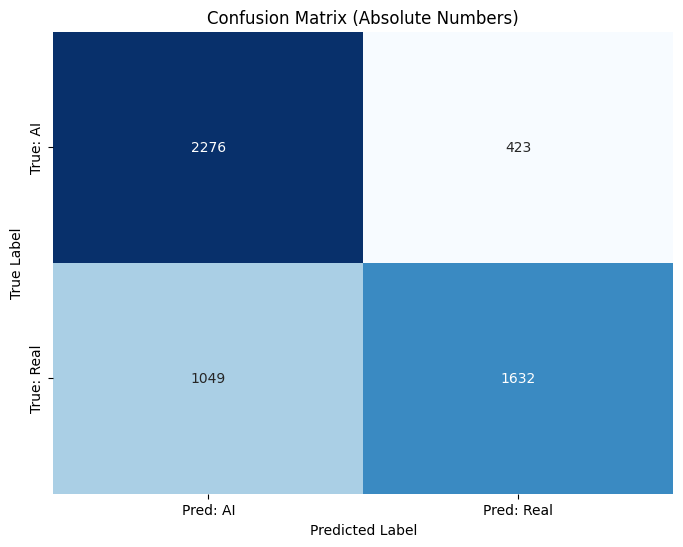

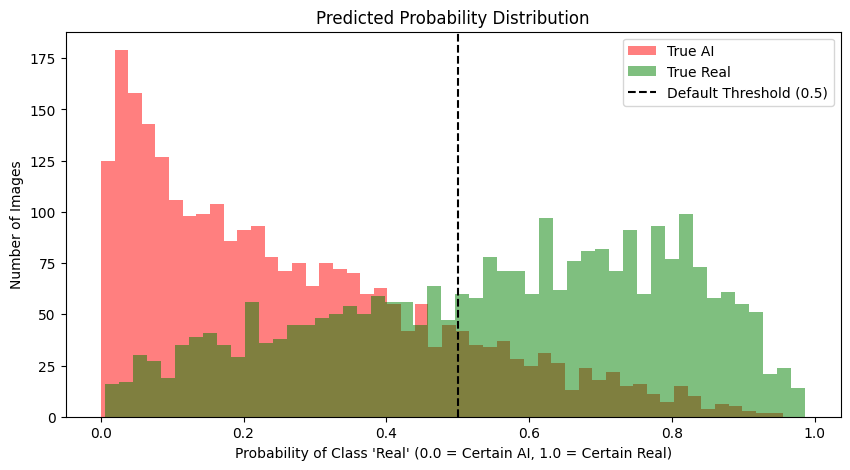

------------------------------
Best Threshold for Class 1 (Real): 0.2523
Best F1-Score: 0.7426
------------------------------
                  precision    recall  f1-score   support

AI Generated (0)       0.79      0.56      0.65      2699
  Real Photo (1)       0.66      0.85      0.74      2681

        accuracy                           0.71      5380
       macro avg       0.73      0.71      0.70      5380
    weighted avg       0.73      0.71      0.70      5380



In [ ]:
print(classification_report(y_test_new, preds_new, target_names=["AI Generated (0)", "Real Photo (1)"]))

f1 = f1_score(y_test_new, preds_new, average='weighted')
roc_auc = roc_auc_score(y_test_new, probs_new)

print(f"Weighted F1-Score: {f1:.4f}")
print(f"ROC-AUC Score:   {roc_auc:.4f}")
print("-" * 30)

cm = confusion_matrix(y_test_new, preds_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Pred: AI", "Pred: Real"],
            yticklabels=["True: AI", "True: Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Absolute Numbers)")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(probs_new[y_test_new == 0], bins=50, alpha=0.5, color='red', label='True AI')
plt.hist(probs_new[y_test_new == 1], bins=50, alpha=0.5, color='green', label='True Real')
plt.axvline(0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.title("Predicted Probability Distribution")
plt.xlabel("Probability of Class 'Real' (0.0 = Certain AI, 1.0 = Certain Real)")
plt.ylabel("Number of Images")
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test_new, probs_new)

fscore = (2 * precision * recall) / (precision + recall + 1e-10)
ix = np.argmax(fscore)
best_thresh = thresholds[ix]
print("-" * 30)

print(f"Best Threshold for Class 1 (Real): {best_thresh:.4f}")
print(f"Best F1-Score: {fscore[ix]:.4f}")
print("-" * 30)

new_preds = (probs_new >= best_thresh).astype(int)
print(classification_report(y_test_new, new_preds, target_names=["AI Generated (0)", "Real Photo (1)"]))

# Contrastive Loss

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet_path = "/kaggle/input/resnet-50-ai-check/pytorch/default/1/resnet50_model_checkpoint.pth"
resnet_con = torch.load(resnet_path, map_location=device, weights_only=False)

if hasattr(resnet_con, 'fc'):
    resnet_con.fc = nn.Identity()
elif hasattr(resnet_con, 'classifier'):
    resnet_con.classifier = nn.Identity()

swin_path = "/kaggle/input/swin-t-ai-check/pytorch/default/1/swin-t_model_checkpoint.pth"
swin = torch.load(swin_path, map_location=device, weights_only=False)
swin.eval()
for param in swin.parameters():
    param.requires_grad = False

clip_model = CLIPModel.from_pretrained("/kaggle/input/clip/transformers/default/1").to(device)
clip_model.eval()
for param in clip_model.parameters():
    param.requires_grad = False

In [ ]:
class ContrastiveNet(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.head(features)
        return F.normalize(embeddings, p=2, dim=1)

model_con = ContrastiveNet(resnet_con).to(device)

for param in model_con.parameters():
    param.requires_grad = False
for param in model_con.backbone.layer4.parameters():
    param.requires_grad = True
for param in model_con.head.parameters():
    param.requires_grad = True

loss_func = losses.TripletMarginLoss(margin=0.2)
miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="semihard")
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_con.parameters()), lr=0.0001)

In [ ]:
model_con.train()
epochs = 1

for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        embeddings = model_con(images)
        hard_pairs = miner(embeddings, labels)
        loss = loss_func(embeddings, labels, hard_pairs)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {epoch_loss / len(train_dataloader)}")

In [ ]:
model_con.eval()

def extract_features_final(dataloader):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)

            emb_resnet = model_con.backbone(images)
            emb_swin = swin(images)

            images_resized = F.interpolate(images, size=(224, 224), mode='bicubic')
            emb_clip = clip_model.get_image_features(pixel_values=images_resized)

            f1 = emb_resnet.cpu().numpy()
            f2 = emb_swin.cpu().numpy()
            f3 = emb_clip.cpu().numpy()

            batch_features = np.concatenate([f1, f2, f3], axis=1)
            features_list.append(batch_features)
            labels_list.append(labels.numpy())

    return np.concatenate(features_list, axis=0), np.concatenate(labels_list, axis=0)

X_train_new, y_train_new = extract_features_final(train_dataloader)

X_test_new, y_test_new = extract_features_final(test_dataloader)

In [ ]:
clf_f = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    task_type="GPU" if torch.cuda.is_available() else "CPU",
    verbose=200,
    early_stopping_rounds=100,
    random_seed=SEED
)

clf_f.fit(
    X_train_new, y_train_new,
    eval_set=(X_test_new, y_test_new),
    plot=False
)

preds_new = clf_f.predict(X_test_new)
print(classification_report(y_test_new, preds_new))

0:	learn: 0.9940288	test: 0.9685874	best: 0.9685874 (0)	total: 13.3s	remaining: 7h 21m 57s
200:	learn: 0.9986292	test: 0.9756506	best: 0.9758364 (165)	total: 44.4s	remaining: 6m 37s
bestTest = 0.9758364312
bestIteration = 165
Shrink model to first 166 iterations.
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2699
           1       0.98      0.97      0.98      2681

    accuracy                           0.98      5380
   macro avg       0.98      0.98      0.98      5380
weighted avg       0.98      0.98      0.98      5380



In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)


def unnormalize(tensor):
    return (tensor.cpu() * std + mean).clamp(0, 1)

preds_final = clf_f.predict(X_test_new)
probs_final = clf_f.predict_proba(X_test_new)

mistakes_idx = np.where(preds_final != y_test_new)[0]
print(f"{len(mistakes_idx)} из {len(y_test_new)}")

if len(mistakes_idx) > 0:
    np.random.shuffle(mistakes_idx)
    plt.figure(figsize=(16, 12))

    for i in range(min(12, len(mistakes_idx))):
        idx = mistakes_idx[i]
        ax = plt.subplot(3, 4, i + 1)

        img_tensor, _ = test_dataloader.dataset[idx]
        img_show = unnormalize(img_tensor).permute(1, 2, 0).numpy()

        true_label = y_test_new[idx]
        pred_label = preds_final[idx]
        confidence = probs_final[idx].max()

        plt.imshow(img_show)
        plt.title(f"Idx: {idx}\nTrue: {true_label} | Pred: {pred_label}\nConf: {confidence:.2%}", color='red')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

                  precision    recall  f1-score   support

AI Generated (0)       0.97      0.98      0.98      2699
  Real Photo (1)       0.98      0.97      0.98      2681

        accuracy                           0.98      5380
       macro avg       0.98      0.98      0.98      5380
    weighted avg       0.98      0.98      0.98      5380

Weighted F1-Score: 0.9758
ROC-AUC Score:   0.9973
------------------------------


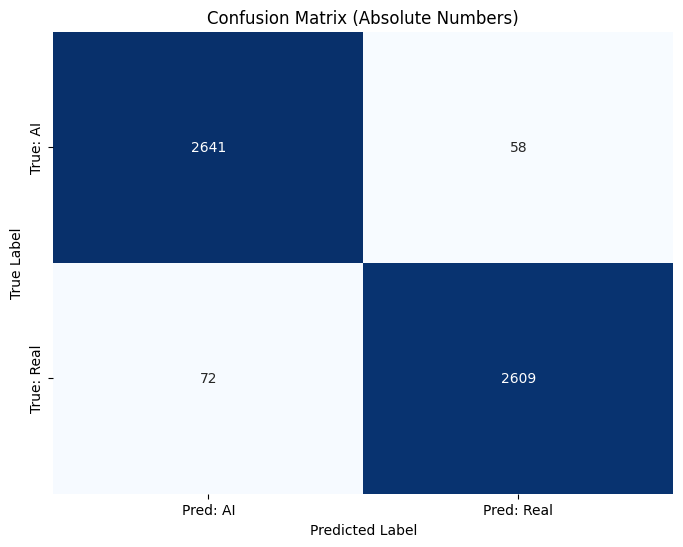

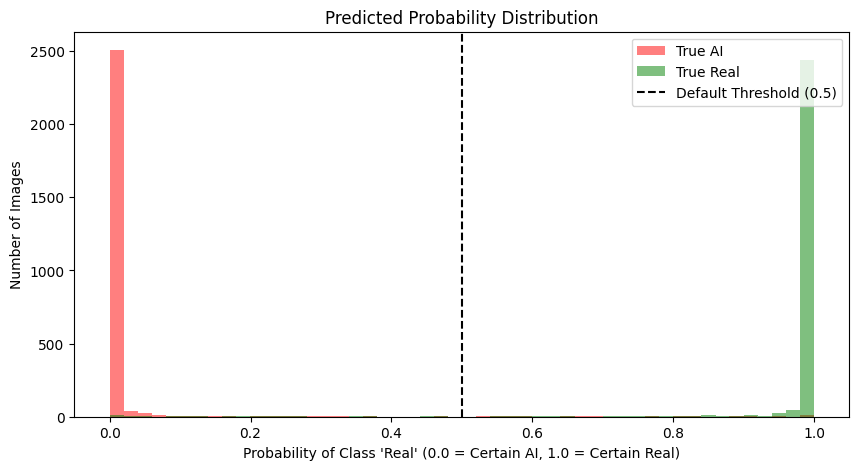

------------------------------
Best Threshold for Class 1 (Real): 0.5842
Best F1-Score: 0.9765
------------------------------
                  precision    recall  f1-score   support

AI Generated (0)       0.97      0.98      0.98      2699
  Real Photo (1)       0.98      0.97      0.98      2681

        accuracy                           0.98      5380
       macro avg       0.98      0.98      0.98      5380
    weighted avg       0.98      0.98      0.98      5380



In [ ]:
probs_new = clf_f.predict_proba(X_test_new)[:, 1]
preds_new = clf_f.predict(X_test_new)

print(classification_report(y_test_new, preds_new, target_names=["AI Generated (0)", "Real Photo (1)"]))

f1 = f1_score(y_test_new, preds_new, average='weighted')
roc_auc = roc_auc_score(y_test_new, probs_new)

print(f"Weighted F1-Score: {f1:.4f}")
print(f"ROC-AUC Score:   {roc_auc:.4f}")
print("-" * 30)

cm = confusion_matrix(y_test_new, preds_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Pred: AI", "Pred: Real"],
            yticklabels=["True: AI", "True: Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Absolute Numbers)")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(probs_new[y_test_new == 0], bins=50, alpha=0.5, color='red', label='True AI')
plt.hist(probs_new[y_test_new == 1], bins=50, alpha=0.5, color='green', label='True Real')
plt.axvline(0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.title("Predicted Probability Distribution")
plt.xlabel("Probability of Class 'Real' (0.0 = Certain AI, 1.0 = Certain Real)")
plt.ylabel("Number of Images")
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test_new, probs_new)

fscore = (2 * precision * recall) / (precision + recall + 1e-10)
ix = np.argmax(fscore)
best_thresh = thresholds[ix]
print("-" * 30)

print(f"Best Threshold for Class 1 (Real): {best_thresh:.4f}")
print(f"Best F1-Score: {fscore[ix]:.4f}")
print("-" * 30)

new_preds = (probs_new >= best_thresh).astype(int)
print(classification_report(y_test_new, new_preds, target_names=["AI Generated (0)", "Real Photo (1)"]))

In [ ]:
clf_f.save_model("ensemble_contrastive.cbm")